#  PySpark - Feature Selection improve fraud detection accuracy




## Goal

To examplify the feature selection strategy in PySpark and furhter enhanc the pyspark pipeline's performance on fraud detection. 

In this project, I will continue to work on the data from the project [fradu_detection_ML_PySpark](https://github.com/tankwin08/PySpark_Fraud_detection_ML). The data exploration will be same, and the feature selction will use input perturbation strtegry instead of PCA as I did in the previous project.


## Why [feature selection](https://mlwhiz.com/blog/2019/08/07/feature_selection/?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com)? 

**1. Curse of dimensionality — Overfitting**

The common theme of the problems is that when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. This sparsity is problematic for any method that requires statistical significance. 

In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality.

Also, organizing and searching data often relies on detecting areas where objects form groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data organization strategies from being efficient.

**2. Occam’s Razor**

We want our models to be simple and explainable. We lose explainability when we have a lot of features.

**3 Noise in the data**

In real applications, the data are not perfect and always noisy inherently. 


## Commonly used methods for feature selection

In summary, there are several commonly used methods to conduct feature selction in data preprocessing.

**1 Correlation or chi-square**

Chose the top-n high correlated variables or high chi-squre variables with respective to target variables.
The intuition is that if a feature is independent to the target, it will not be useful or uninformative for target classification or regression.

**2 Stepwise method**

This is a wrapper based method. The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

**3 Lasso - Penalized likelihood **

LASSO models have been used extensively in high-dimensional model selection problems, that is when the number of IVs 𝑘 by far exceeds the sample size 𝑛. 

Regression coefficients estimated by the LASSO are biased by intention, but can have smaller mean squared error (MSE) than conventional estimates. It prefer to have fewer variales with huge contribution to the target.

Because of the bias, their interpretation in explanatory or descriptive models is difficult, and confidence intervals based on resampling procedures such as the percentile bootstrap do not reach their claimed nominal level. Another problem with LASSO estimation is its dependence on the scale of the covariates

**4 PCA**

PCA is a commonly used as dimension reduction technique by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. 

The advantages of PCA:

1. Removes Correlated Features
2. Improves Algorithm Performance
3. Reduces Overfitting
4. Improves Visualization

The things we need to consider before using PCA:

1.	Independent variables become less interpretable: 
2.	Data standardization is must before PCA: pca is affected by scale
3.	Information loss



**5 Input Perturbation**

This algorithm was introduced by [Breiman](https://en.wikipedia.org/wiki/Leo_Breiman) in his seminal paper on random forests.  Although he presented this algorithm in conjunction with random forests, it is model-independent and appropriate for any supervised learning model.  

This algorithm, known as the input perturbation algorithm, works by evaluating a trained model’s accuracy with each of the inputs individually shuffled from a data set.  Shuffling an input causes it to become useless—effectively removing it from the model. More important inputs will produce a less accurate score when they are removed by shuffling them. This process makes sense, because important features will contribute to the accuracy of the model. 


The code was coming from [here](https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/).

The variable importance can be used in other analysis.

## Data

The data of this project can be downloaded from [here](https://www.kaggle.com/ntnu-testimon/paysim1).

The explanation columns of input data:

**One row**: 1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

**Column names with explanition**: 

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.


## Setup pyspark

If this is your first time to set up pyspark, please follow the [intructions](https://medium.com/@naomi.fridman/install-pyspark-to-run-on-jupyter-notebook-on-windows-4ec2009de21f) to set it up properly.


In [1]:
import findspark
findspark.init()
findspark.find()

'C:\\spark\\spark-2.4.6-bin-hadoop2.7'

In [100]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, VectorSlicer

## 1 Import data

In [3]:
sc = SparkContext(appName="finicial fraud detection")
sqlc = SQLContext(sc)

In [4]:
## data
data_file = './data/PS_20174392719_1491204439457_log.csv'
data = sqlc.read.csv(data_file,header = True)

## 2 Data exploration

In [5]:
data.count()

6362620

In [6]:
data.dtypes

[('step', 'string'),
 ('type', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('isFraud', 'string'),
 ('isFlaggedFraud', 'string')]

In [7]:
data.limit(3).toPandas()

step      type   amount     nameOrig oldbalanceOrg newbalanceOrig  \
0    1   PAYMENT  9839.64  C1231006815      170136.0      160296.36   
1    1   PAYMENT  1864.28  C1666544295       21249.0       19384.72   
2    1  TRANSFER    181.0  C1305486145         181.0            0.0   

      nameDest oldbalanceDest newbalanceDest isFraud isFlaggedFraud  
0  M1979787155            0.0            0.0       0              0  
1  M2044282225            0.0            0.0       0              0  
2   C553264065            0.0            0.0       1              0

In [8]:
data.groupBy('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
|      1|   8213|
+-------+-------+



**Tips:** We can see this is imblance data and we should use stratified split method in the following operation

In [9]:
### check if there is missing values in the data
from pyspark.sql.functions import col,sum
data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in data.columns)).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### 2.1 Understand the data which belongs to fraudulent

In [11]:
subd = data.filter(data['isFraud'] == 1).groupby('type').count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER| 4097|
|CASH_OUT| 4116|
+--------+-----+



**Observation**: it looks only type is TRANSFER or CASH_OUT will be fraud.

In [12]:
data.groupby('isFlaggedFraud').count().show()

+--------------+-------+
|isFlaggedFraud|  count|
+--------------+-------+
|             0|6362604|
|             1|     16|
+--------------+-------+



### 2.2 check if this is consistent with the decription of the column that more than 200,200 will be conisdered as illegeal

In [17]:
data.filter(data['isFlaggedFraud'] == 1).orderBy('amount').show()

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| 425|TRANSFER|     1.0E7| C689608084|1.958504037E7| 1.958504037E7|C1392803603|           0.0|           0.0|      1|             1|
| 730|TRANSFER|     1.0E7|C2140038573|1.731625505E7| 1.731625505E7|C1395467927|           0.0|           0.0|      1|             1|
| 646|TRANSFER|     1.0E7|  C19004745|1.039904508E7| 1.039904508E7|C1806199534|           0.0|           0.0|      1|             1|
| 250|TRANSFER|1343002.08|C1100582606|   1343002.08|    1343002.08|C1147517658|           0.0|           0.0|      1|             1|
| 617|TRANSFER|2542664.27| C786455622|   2542664.27|    2542664.27| C

### Check the min and max of the values when it's flagged as fraud

In [18]:
max1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "max"}).collect()[0]
min1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "min"}).collect()[0]

In [19]:
max1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "mean"}).collect()[0]

In [20]:
data.groupBy(['isFlaggedFraud']).agg({'amount':'avg','isFlaggedFraud':'count'}).show()

+--------------+------------------+---------------------+
|isFlaggedFraud|       avg(amount)|count(isFlaggedFraud)|
+--------------+------------------+---------------------+
|             0|179850.13041768773|              6362604|
|             1|    4861597.730625|                   16|
+--------------+------------------+---------------------+



### Multiple columns and multiple functions

In [21]:
from pyspark.sql.functions import mean, sum, max, col,count
groupBy = ["isFlaggedFraud"]
aggregate = ["amount"] 
funs = [mean, sum, max,count]

exprs = [f(col(c)) for f in funs for c in aggregate]

In [22]:
re1 = data.groupby(*groupBy).agg(*exprs).collect()

In [23]:
re1

[Row(isFlaggedFraud='0', avg(amount)=179850.13041768366, sum(amount)=1144315159196.0757, max(amount)='99999.81', count(amount)=6362604),
 Row(isFlaggedFraud='1', avg(amount)=4861597.730625, sum(amount)=77785563.69, max(amount)='9585040.37', count(amount)=16)]

In [24]:
max0 = data.filter(data['isFlaggedFraud'] == 0).agg({"amount": "max"}).collect()[0]
min0 = data.filter(data['isFlaggedFraud'] == 0).agg({"amount": "min"}).collect()[0]

In [25]:
max1[0],min1[0],max0[0],min0[0]

(4861597.730625, '1.0E7', '99999.81', '0.0')

**Observations**: Once is flagged as fraud, the destination's account are always zero before and after transcation. It 
    made sense as the transcation will be halted when it's flagged as fraud.

In [26]:
data.filter( (data['isFlaggedFraud'] == 0) & (data['oldbalanceDest'] ==0) & (data['newbalanceDest'] ==0)).show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 7817.71|  C90045638|      53860.0|      46042.29| M573487274|      

In [27]:
### whether the account names is duplicated or not when it is flagged as fraud
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameOrig').count().show()

+-----------+-----+
|   nameOrig|count|
+-----------+-----+
|C2140038573|    1|
|C1684585475|    1|
| C452586515|    1|
| C917414431|    1|
| C724693370|    1|
| C728984460|    1|
| C992223106|    1|
|C1869569059|    1|
|  C19004745|    1|
| C908544136|    1|
|C1035541766|    1|
|C1100582606|    1|
| C689608084|    1|
| C193696150|    1|
| C786455622|    1|
|C1892216157|    1|
+-----------+-----+



In [28]:
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameDest').count().show()

+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1806199534|    1|
|C1861208726|    1|
|C1147517658|    1|
|C1395467927|    1|
| C661958277|    1|
|C1392803603|    1|
| C484597480|    1|
|C1909486199|    1|
| C639921569|    1|
|C1082139865|    1|
|C1100697970|    1|
|C1770418982|    1|
|C1308068787|    1|
|C1109166882|    1|
| C891140444|    1|
|C1366804249|    1|
+-----------+-----+



### 2.3. Are expected merchant accounts accordingly labelled?
It was stated <a href='http://www2.bth.se/com/edl.nsf/pages/phd-dissertation'>[5]</a> that CASH_IN involves being paid by
a merchant (whose name is prefixed by 'M'). However, as shown below, the present data does not have
merchants making CASH_IN transactions to customers.

In [29]:
subd1 = data.filter( (data['type'] == 'CASH_IN') & \
                (data['nameOrig'].like('%M%')) ).show(4)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [30]:
subd1 = data.filter( (data['type'] == 'CASH_OUT') & \
                (data['nameOrig'].like('%M%')) ).show(4)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [31]:
data.filter(data['nameDest'].like('%M%')).groupBy('type').count().show()

+-------+-------+
|   type|  count|
+-------+-------+
|PAYMENT|2151495|
+-------+-------+



In [32]:
data.filter( (col('nameDest').isin(col('nameOrig'))) & (data['isFraud'] == 1)).show(5)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### Names of Fraud and not Fraud

In [33]:
df1 = data.filter(data['isFraud'] == 1) ## fraud
df0 = data.filter(data['isFraud'] == 0) ## not fraud

In [34]:
##Get the unique names if the data is fraud
unique_org_names1 = [i.nameOrig for i in df1.select('nameOrig').distinct().collect()]
unique_org_names0 = [i.nameOrig for i in df0.select('nameOrig').distinct().collect()]

In [35]:
# unique_org_names1 = data.select('nameOrig').distinct().rdd.map(lambda r: r[0]).collect()
## work the same as the comprehension

In [36]:
data.filter(col('nameDest').isin(unique_org_names1)).show(5)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that
are not detected and are labeled as genuine? It turns out there are  3 such
accounts.

In [37]:
##take a long time to run, we can used join and broadcase to make it faster
## https://stackoverflow.com/questions/53737952/slow-filtering-of-pyspark-dataframes
#subd = df1.filter(df1['nameDest'].isin(unique_org_names0))

### Faster way to filter when the number of filter is big
It looks didn't work when we join them together

In [38]:
# list_filter_df = sqlc.createDataFrame([[x] for x in unique_org_names0], df1.columns[6:7])

In [39]:
# subd = df1.join(F.broadcast(list_filter_df),df1.columns[6:7])

## 3 Data cleaning

In [46]:
x0 = data.filter(data['type'].isin(['CASH_OUT','TRANSFER']))

In [47]:
data.select(['type']).distinct().show()

+--------+
|    type|
+--------+
|TRANSFER|
| CASH_IN|
|CASH_OUT|
| PAYMENT|
|   DEBIT|
+--------+



##### Destination account - replace zero with -1

In [42]:
### chang 0 to more sensible values for some cases
from pyspark.sql.functions import when
import numpy as np

x0 = x0.withColumn('oldbalanceDest', \
              when((x0['oldbalanceDest'] == 0) & (x0['newbalanceDest'] ==0) & (x0['amount'] !=0), -1).otherwise(x0['oldbalanceDest']))

x0 = x0.withColumn('newbalanceDest', \
              when((x0['oldbalanceDest'] == 0) & (x0['newbalanceDest'] ==0) & (x0['amount'] !=0), -1).otherwise(x0['newbalanceDest']))

In [43]:
##check if the replacement working
##double check the results
x0.agg({"oldbalanceDest": "min"}).collect()[0]

Row(min(oldbalanceDest)='-1')

##### Original account - replace zero with nan

In [44]:
# x0 = x0.withColumn('oldbalanceOrg', \
#               when((x0['oldbalanceOrg'] == 0) & (x0['newbalanceOrig'] ==0) & (x0['amount'] !=0), np.nan).otherwise(x0['oldbalanceOrg']))

# x0 = x0.withColumn('newbalanceOrig', \
#               when((x0['oldbalanceOrg'] == 0) & (x0['newbalanceOrig'] ==0) & (x0['amount'] !=0), np.nan).otherwise(x0['newbalanceOrig']))

#### Convert string to numeric columns

In [48]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
'''x0 is the data frame'''
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(x0) for column in ['type'] ]

pipeline = Pipeline(stages=indexers)
x_r = pipeline.fit(x0).transform(x0)

In [49]:
x_r.limit(5).toPandas()

step      type     amount     nameOrig oldbalanceOrg newbalanceOrig  \
0    1  TRANSFER      181.0  C1305486145         181.0            0.0   
1    1  CASH_OUT      181.0   C840083671         181.0            0.0   
2    1  CASH_OUT  229133.94   C905080434       15325.0            0.0   
3    1  TRANSFER   215310.3  C1670993182         705.0            0.0   
4    1  TRANSFER  311685.89  C1984094095       10835.0            0.0   

      nameDest oldbalanceDest newbalanceDest isFraud isFlaggedFraud  \
0   C553264065            0.0            0.0       1              0   
1    C38997010        21182.0            0.0       1              0   
2   C476402209         5083.0       51513.44       0              0   
3  C1100439041        22425.0            0.0       0              0   
4   C932583850         6267.0     2719172.89       0              0   

   type_index  
0         1.0  
1         0.0  
2         0.0  
3         1.0  
4         1.0

In [50]:
from pyspark.sql.types import IntegerType

In [51]:
xx = x_r.withColumn('type_index',x_r['type_index'].cast(IntegerType()))
xx = xx.withColumn('isFraud',x_r['isFraud'].cast(IntegerType()))

In [52]:
xx = xx.withColumnRenamed('isFraud','label')

In [53]:
xx.limit(5).toPandas()

step      type     amount     nameOrig oldbalanceOrg newbalanceOrig  \
0    1  TRANSFER      181.0  C1305486145         181.0            0.0   
1    1  CASH_OUT      181.0   C840083671         181.0            0.0   
2    1  CASH_OUT  229133.94   C905080434       15325.0            0.0   
3    1  TRANSFER   215310.3  C1670993182         705.0            0.0   
4    1  TRANSFER  311685.89  C1984094095       10835.0            0.0   

      nameDest oldbalanceDest newbalanceDest  label isFlaggedFraud  type_index  
0   C553264065            0.0            0.0      1              0           1  
1    C38997010        21182.0            0.0      1              0           0  
2   C476402209         5083.0       51513.44      0              0           0  
3  C1100439041        22425.0            0.0      0              0           1  
4   C932583850         6267.0     2719172.89      0              0           1

In [54]:
xf = xx.drop('type')

In [55]:
xf.limit(5).toPandas()

step     amount     nameOrig oldbalanceOrg newbalanceOrig     nameDest  \
0    1      181.0  C1305486145         181.0            0.0   C553264065   
1    1      181.0   C840083671         181.0            0.0    C38997010   
2    1  229133.94   C905080434       15325.0            0.0   C476402209   
3    1   215310.3  C1670993182         705.0            0.0  C1100439041   
4    1  311685.89  C1984094095       10835.0            0.0   C932583850   

  oldbalanceDest newbalanceDest  label isFlaggedFraud  type_index  
0            0.0            0.0      1              0           1  
1        21182.0            0.0      1              0           0  
2         5083.0       51513.44      0              0           0  
3        22425.0            0.0      0              0           1  
4         6267.0     2719172.89      0              0           1

## 4 Feature enginering

In [56]:
from pyspark.sql.functions import col

In [57]:
xf = xf.withColumn("errorbalanceOrig", col("newbalanceOrig") + col("amount") - col("oldbalanceOrg"))

In [58]:
xf = xf.withColumn("errorbalanceDest", col("oldbalanceDest") + col("amount") - col("newbalanceDest"))

In [59]:
xf.limit(5).toPandas()

step     amount     nameOrig oldbalanceOrg newbalanceOrig     nameDest  \
0    1      181.0  C1305486145         181.0            0.0   C553264065   
1    1      181.0   C840083671         181.0            0.0    C38997010   
2    1  229133.94   C905080434       15325.0            0.0   C476402209   
3    1   215310.3  C1670993182         705.0            0.0  C1100439041   
4    1  311685.89  C1984094095       10835.0            0.0   C932583850   

  oldbalanceDest newbalanceDest  label isFlaggedFraud  type_index  \
0            0.0            0.0      1              0           1   
1        21182.0            0.0      1              0           0   
2         5083.0       51513.44      0              0           0   
3        22425.0            0.0      0              0           1   
4         6267.0     2719172.89      0              0           1   

   errorbalanceOrig  errorbalanceDest  
0              0.00             181.0  
1              0.00           21363.0  
2         213808.94          182703.5  
3         214605.30          237735.3  
4         300850.89        -2401220.0

## convert data frame types

In [53]:
yv = ['isFraud']
xv = ['step',
      'type_index',
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest',"errorbalanceOrig","errorbalanceDest"]


In [60]:
xf.dtypes

[('step', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

### Convert Variables types to float

In [63]:
sxv = ['step',
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest']
for col_name in sxv:
    xf = xf.withColumn(col_name, col(col_n ame).cast('float'))

In [64]:
xf.dtypes

[('step', 'float'),
 ('amount', 'float'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'float'),
 ('newbalanceOrig', 'float'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'float'),
 ('newbalanceDest', 'float'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

## 5 Train and test data split

In [65]:
from pyspark.sql.functions import lit

### stratified split

Here I used stratified split instead of random split which can overcome the imblance data problem.

In [66]:
fractions = xf.select("label").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
df_train = xf.sampleBy('label',fractions,seed=17)
df_test = xf.subtract(df_train)

## 6 Model - pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator,  TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [71]:
yv = ['label']
xv = ['step','type_index','amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest',"errorbalanceOrig","errorbalanceDest"]

### 6.1 convert dataframe to vector

In [79]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols= xv, outputCol="features")

### 6.2 Create a RF classifer

In [80]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

### 6.3 Creating a Multiclass Classification Evaluator

In [81]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()  

### Creating  a Pipeline

This will be easier when we need to test different scenarios.

In [87]:
from pyspark.ml import Pipeline
import pandas as pd
##NO pca
pipeline = Pipeline(stages=[vecAssembler, rf])

## 7 Feature importances

In [84]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [83]:
mod = pipeline.fit(df_train)

In [85]:
pred_train = mod.transform(df_train) ##get the predicted train values

In [92]:
mod.stages[-1].featureImportances

SparseVector(9, {0: 0.041, 1: 0.0895, 2: 0.1529, 3: 0.0278, 4: 0.3753, 5: 0.0428, 6: 0.0378, 7: 0.1536, 8: 0.0793})

In [88]:
ExtractFeatureImp(mod.stages[-1].featureImportances, pred_train, "features").head(10)

idx              name     score
4    4    newbalanceOrig  0.375331
7    7  errorbalanceOrig  0.153630
2    2            amount  0.152874
1    1        type_index  0.089467
8    8  errorbalanceDest  0.079343
5    5    oldbalanceDest  0.042793
0    0              step  0.040988
6    6    newbalanceDest  0.037770
3    3     oldbalanceOrg  0.027804

In [94]:
num_feas = 4

In [95]:
varlist = ExtractFeatureImp(mod.stages[-1].featureImportances, pred_train, "features")
varidx = [x for x in varlist['idx'][0:num_feas]]

## Used important varaibles for modelling

In [101]:
slicer = VectorSlicer(inputCol="features", outputCol="features2", indices=varidx)
train_input = slicer.transform(pred_train)

In [98]:
pred_train.limit(3).toPandas()

step       amount     nameOrig  oldbalanceOrg  newbalanceOrig    nameDest  \
0   1.0     181.0000  C1305486145          181.0             0.0  C553264065   
1   1.0     181.0000   C840083671          181.0             0.0   C38997010   
2   1.0  229133.9375   C905080434        15325.0             0.0  C476402209   

   oldbalanceDest  newbalanceDest  label isFlaggedFraud  type_index  \
0             0.0        0.000000      1              0           1   
1         21182.0        0.000000      1              0           0   
2          5083.0    51513.441406      0              0           0   

   errorbalanceOrig  errorbalanceDest  \
0              0.00             181.0   
1              0.00           21363.0   
2         213808.94          182703.5   

                                            features  \
0  [1.0, 1.0, 181.0, 181.0, 0.0, 0.0, 0.0, 0.0, 1...   
1  [1.0, 0.0, 181.0, 181.0, 0.0, 21182.0, 0.0, 0....   
2  [1.0, 0.0, 229133.9375, 15325.0, 0.0, 5083.0, ...   

                               rawPrediction  \
0    [8.283436623346606, 11.716563376653394]   
1    [13.557571613380896, 6.442428386619106]   
2  [19.974578470058308, 0.02542152994169122]   

                                  probability  prediction  
0    [0.4141718311673303, 0.5858281688326696]         1.0  
1    [0.6778785806690448, 0.3221214193309553]         0.0  
2  [0.9987289235029154, 0.001271076497084561]         0.0

In [102]:
train_input.limit(3).toPandas()

step       amount     nameOrig  oldbalanceOrg  newbalanceOrig    nameDest  \
0   1.0     181.0000  C1305486145          181.0             0.0  C553264065   
1   1.0     181.0000   C840083671          181.0             0.0   C38997010   
2   1.0  229133.9375   C905080434        15325.0             0.0  C476402209   

   oldbalanceDest  newbalanceDest  label isFlaggedFraud  type_index  \
0             0.0        0.000000      1              0           1   
1         21182.0        0.000000      1              0           0   
2          5083.0    51513.441406      0              0           0   

   errorbalanceOrig  errorbalanceDest  \
0              0.00             181.0   
1              0.00           21363.0   
2         213808.94          182703.5   

                                            features  \
0  [1.0, 1.0, 181.0, 181.0, 0.0, 0.0, 0.0, 0.0, 1...   
1  [1.0, 0.0, 181.0, 181.0, 0.0, 21182.0, 0.0, 0....   
2  [1.0, 0.0, 229133.9375, 15325.0, 0.0, 5083.0, ...   

                               rawPrediction  \
0    [8.283436623346606, 11.716563376653394]   
1    [13.557571613380896, 6.442428386619106]   
2  [19.974578470058308, 0.02542152994169122]   

                                  probability  prediction  \
0    [0.4141718311673303, 0.5858281688326696]         1.0   
1    [0.6778785806690448, 0.3221214193309553]         0.0   
2  [0.9987289235029154, 0.001271076497084561]         0.0   

                            features2  
0              [0.0, 0.0, 181.0, 1.0]  
1              [0.0, 0.0, 181.0, 0.0]  
2  [0.0, 213808.94, 229133.9375, 0.0]

In [103]:
train_input = train_input.drop('rawPrediction', 'probability', 'prediction')
rf2 = RandomForestClassifier(labelCol="label", featuresCol="features2")
mod2 = rf2.fit(train_input)

In [104]:
##prediction at the train data
pred_train2 = mod2.transform(train_input)

### Prediction for test data

In [105]:
df_test.limit(3).toPandas()

step         amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   2.0  183763.578125  C2038185019           31.0             0.0   
1   2.0  521278.468750  C1418310135            0.0             0.0   
2   5.0   83160.078125   C159116975            0.0             0.0   

      nameDest  oldbalanceDest  newbalanceDest  label isFlaggedFraud  \
0  C1963862935             0.0    1.837636e+05      0              0   
1   C306206744       6273401.5    7.173524e+06      0              0   
2   C306206744       7129559.5    6.778202e+06      0              0   

   type_index  errorbalanceOrig  errorbalanceDest  
0           1         183732.58              0.00  
1           1         521278.47        -378843.30  
2           0          83160.08         434517.44

In [109]:
test_pred = mod.transform(df_test)

In [111]:
test_pred.limit(3).toPandas()

step         amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   2.0  183763.578125  C2038185019           31.0             0.0   
1   2.0  521278.468750  C1418310135            0.0             0.0   
2   5.0   83160.078125   C159116975            0.0             0.0   

      nameDest  oldbalanceDest  newbalanceDest  label isFlaggedFraud  \
0  C1963862935             0.0    1.837636e+05      0              0   
1   C306206744       6273401.5    7.173524e+06      0              0   
2   C306206744       7129559.5    6.778202e+06      0              0   

   type_index  errorbalanceOrig  errorbalanceDest  \
0           1         183732.58              0.00   
1           1         521278.47        -378843.30   
2           0          83160.08         434517.44   

                                            features  \
0  [2.0, 1.0, 183763.578125, 31.0, 0.0, 0.0, 1837...   
1  [2.0, 1.0, 521278.46875, 0.0, 0.0, 6273401.5, ...   
2  [5.0, 0.0, 83160.078125, 0.0, 0.0, 7129559.5, ...   

                                 rawPrediction  \
0  [19.995352754917082, 0.0046472450829186185]   
1    [19.99604180796363, 0.003958192036373334]   
2   [19.99680078588465, 0.0031992141153539106]   

                                    probability  prediction  
0  [0.9997676377458541, 0.00023236225414593093]         0.0  
1   [0.9998020903981815, 0.0001979096018186667]         0.0  
2   [0.9998400392942323, 0.0001599607057676955]         0.0

### prediction at test data using model2

In [112]:
slicer = VectorSlicer(inputCol="features", outputCol="features2", indices=varidx)
test_pred = slicer.transform(test_pred)

test_input = test_pred.drop('rawPrediction', 'probability', 'prediction')

In [113]:
test_pred2 = mod2.transform(test_input)

## 7.2 Use pipeline add the feature selction

In [114]:
from FeatureImportanceSelector import ExtractFeatureImp, FeatureImpSelector

In [115]:
## convert dataframe to vector
vecAssembler = VectorAssembler(inputCols= xv, outputCol="features")
##RF models
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
##feature selection, which includerf. thus, no need to put it in the pipeline
fis = FeatureImpSelector(estimator = rf, selectorType = "numTopFeatures",
                         numTopFeatures = 5, outputCol = "features_subset")

rf2 = RandomForestClassifier(labelCol="label", featuresCol="features_subset")

In [116]:
pipe1 = Pipeline(stages = [vecAssembler, fis, rf2])

In [117]:
## no hyperparameter tunning
model_pipe = pipe1.fit(df_train)

### Evaluation -  good results

In [118]:
test_pred1 = model_pipe.transform(df_test)
evaluator.evaluate(test_pred1)

0.9999837743687627

In [120]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [124]:
y_test = test_pred1.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
y_test_pred = test_pred1.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()

In [125]:
cm_test = confusion_matrix(y_test, y_test_pred)

In [126]:
cm_test

array([[553790,      0],
       [     9,   1637]], dtype=int64)

### Observation:

Compared with previous results using PCA without any feature selection, this one is much better

## 8 Hyperparameter tunning

### Creating Grid Search Configuration 

In [127]:
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .addGrid(rf.impurity, ['gini', 'entropy'])
             .build())

def get_validation(by='cv'):
    if by is 'cv': ##cross validation
        return CrossValidator(
            estimator=pipe1,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=10)
    
    elif by is 'tvs': ##train and test split
        return TrainValidationSplit(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            # 80% of the data will be used for training, 20% for validation.
            trainRatio=0.8)
    else:
        print('please, pick either cv or tvs')
        return None
    
def evaluate(model, df_train, df_test):
    train_pred = model.transform(df_train)
    train_acc = evaluator.evaluate(train_pred)
    
    test_pred = model.transform(df_test)
    test_acc = evaluator.evaluate(test_pred)
    
    print('train_acc: {}, test_acc: {}'.format(train_acc, test_acc))
    
    return train_pred, test_pred

In [129]:
val = get_validation('cv')
model_cv = val.fit(df_train)

## Best model

In [130]:
bestModel = model_cv.bestModel
finalPredictions = bestModel.transform(df_train)
evaluator.evaluate(finalPredictions)

0.9999877995749361

### Get the hyper-paramters of the best model

In [131]:
bestModel.stages[-1]._java_obj.getImpurity()

'gini'

In [132]:
bestModel.stages[-1]._java_obj.getMaxDepth()

5

In [133]:
bestModel.stages[-1]._java_obj.getMaxBins()

32

In [134]:
bestModel.stages[-1]._java_obj.getNumTrees()

20

#### it's weired that the paramters are empty when tried the following way

In [135]:
{param[0].name: param[1] for param in bestModel.extractParamMap().items()}

{}

## Evalution of Model - Accuracy

In [136]:
train_pred, test_pred = evaluate(model_cv, df_train, df_test)

train_acc: 0.9999877995749361, test_acc: 0.9999837743687627


## Evalution of Model - Precision - Recall

In [137]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

class Util:
        
    def report_classification(model, df_train, df_test, X_features, y_feature):
        
        classes_train = np.unique(df_train[y_feature].values).tolist()
        classes_test = np.unique(df_test[y_feature].values).tolist()
        
        assert (classes_train == classes_test)
        
        classes = classes_train # The order of class is important!
        
        X_train = df_train[X_features].values.tolist()
        X_test = df_test[X_features].values.tolist()
        
        y_train = df_train[y_feature].values.tolist()
        y_test = df_test[y_feature].values.tolist()
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)
        
    def report_cm(y_train, y_test, y_train_pred, y_test_pred, classes):
        figure, axes = plt.subplots(1, 2, figsize=(10,5))

        cm_test = confusion_matrix(y_test, y_test_pred)
        df_cm_test = pd.DataFrame(cm_test, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_test, annot=True, ax = axes[0], square= True)
        ax.set_title('Test CM')

        cm_train = confusion_matrix(y_train, y_train_pred)
        df_cm_train = pd.DataFrame(cm_train, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_train, annot=True, ax = axes[1], square= True)
        ax.set_title('Train CM')

        print('-' * 20 + 'Testing Performance' + '-' * 20)
        print(classification_report(y_test, y_test_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_test, y_test_pred))

        print('-' * 20 + 'Training Performance' + '-' * 20)
        print(classification_report(y_train, y_train_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_train, y_train_pred))

--------------------Testing Performance--------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553790
           1       1.00      0.99      1.00      1646

    accuracy                           1.00    555436
   macro avg       1.00      1.00      1.00    555436
weighted avg       1.00      1.00      1.00    555436

acc:  0.9999837965130096
--------------------Training Performance--------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2208406
           1       1.00      1.00      1.00      6567

    accuracy                           1.00   2214973
   macro avg       1.00      1.00      1.00   2214973
weighted avg       1.00      1.00      1.00   2214973

acc:  0.9999878102351586


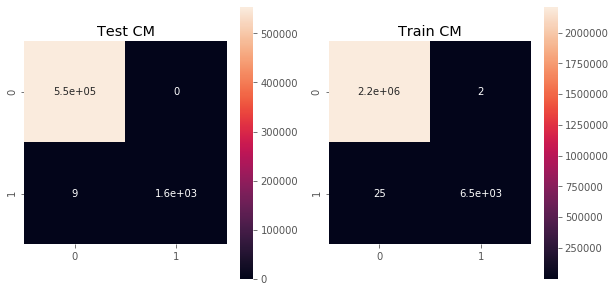

In [138]:
y_train = train_pred.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
y_train_pred = train_pred.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()

y_test = test_pred.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
y_train_test = test_pred.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()

Util.report_cm(y_train, y_test, y_train_pred, y_train_test, ['0', '1'])

In [139]:
selected = train_pred.select("label", "prediction", "probability")
display(selected.show(10))

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.02019661823323...|
|    1|       1.0|[0.05009101775589...|
|    0|       0.0|[0.99991422895779...|
|    0|       0.0|[0.99978552830334...|
|    0|       0.0|[0.99991422895779...|
|    0|       0.0|[0.99991422895779...|
|    0|       0.0|[0.99998781017810...|
|    0|       0.0|[0.99998781017810...|
|    0|       0.0|[0.96980222431356...|
|    0|       0.0|[0.99991422895779...|
+-----+----------+--------------------+
only showing top 10 rows



None

## Conclusions

With the feature selction, we can significantly increase the model performances comapred to only used the PCA strategies.